Large-Amplitude Pendulum
=======================

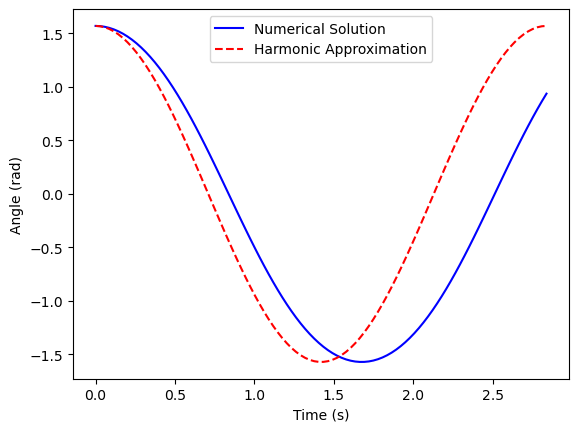

In [1]:
import numpy as np 
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Function that computes the derivatives
def dfdt(y0,t,params):
    theta, omega = y0
    GdivL, = params
    derivs = [omega, -GdivL * np.sin(theta)]
    return derivs

# Initial conditions 
theta0 = np.pi/2.0
omega0 = 0.0
y0 = [theta0, omega0]

# Parameters
GdivL = 4.9
params = [GdivL]
Omega = np.sqrt(GdivL) # natural frequency 
period = 2.0 * np.pi / Omega


# List of Times
t = np.linspace(0.0, 1.0 * period, 100)
ThetaHar = theta0 * np.cos(Omega * t)

# Solution and plot
sol = odeint(dfdt, y0, t, args=(params,))
theta = sol[:,0]
plt.plot(t, theta, 'b-', label='Numerical Solution')
plt.plot(t, ThetaHar, 'r--', label='Harmonic Approximation')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.legend()
plt.show()

Shooting method for solving the nonlinear boundary value problem of a large-amplitude pendulum.

Eigenvalue  0  :  0.020379039558320065
Eigenvalue  1  :  0.08135854377527724
Eigenvalue  2  :  0.18242255694567575
Eigenvalue  3  :  0.32253401753318034
Eigenvalue  4  :  0.4996922435123998
Eigenvalue  5  :  0.7095036785796405
Eigenvalue  6  :  0.9368079820026474
Eigenvalue  6  :  0.9368079820026474


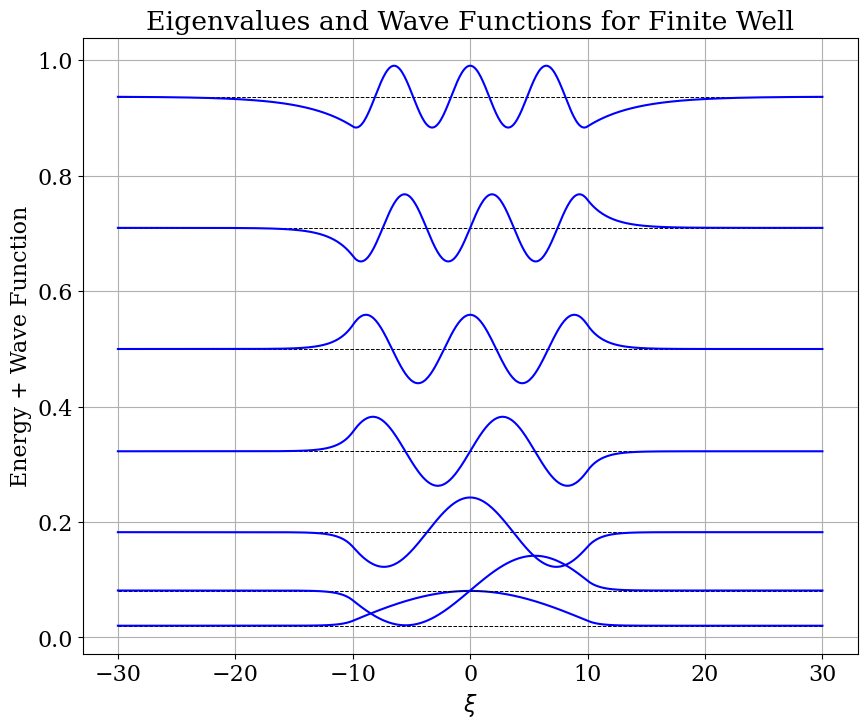

In [11]:
import numpy as np
from scipy.integrate import odeint, simpson
import matplotlib.pyplot as plt

# select plot fonts
plt.rcParams.update({'font.size': 16, 'font.family': 'serif'})

xi0 = 10.0  # right boundary
nPointsWell = 100
nPointsPlot = 3 * nPointsWell
nPoints = 5 * nPointsWell
scale = 0.2
xiMaxPlot = (xi0 * nPointsPlot) / nPointsWell
xiMax = (xi0 * nPoints) / nPointsWell  # far right boundary for integration
EigvStep = 0.03
DeltaXi = xi0 / nPointsWell
tol = 1.0e-12
params = [0, xi0]

WaveFun = np.array([])
xi = np.linspace(0.0, xiMax, nPoints)

# derivatives of the wave function
def dfdxi(y, xi, params):
    psi, dpsidxi = y  # unpack y
    E, xi0 = params  # unpack params
    if xi < xi0:
        derivs = [dpsidxi, -E * psi]
    else:
        derivs = [dpsidxi, (1 - E) * psi]
    return derivs

def SymmWell(params, xi, iEv, EigvStart, EigvStep, tol, dfdxi, psi):
    # Initialization
    eigv1 = EigvStart
    params[0] = eigv1
    if iEv % 2 == 0:
        y = [1.0, 0.0]  # even parity
    else:
        y = [0.0, 1.0]  # odd parity
    # integrate ODE
    psoln = odeint(dfdxi, y, xi, args=(params,))
    PsiEnd1 = psoln[-1, 0]

    # Search for interval
    while True:
        eigv2 = eigv1 + EigvStep
        if eigv2 > 1.0:
            return -1
        params[0] = eigv2
        psoln = odeint(dfdxi, y, xi, args=(params,))
        PsiEnd2 = psoln[-1, 0]
        if PsiEnd1 * PsiEnd2 < 0.0:
            break
        PsiEnd1 = PsiEnd2
        eigv1 = eigv2

    # Bisection search for eigenvalue
    while True:
        eigvmid = (eigv1 + eigv2) / 2.0
        if abs(eigv2 - eigv1) < tol:
            break
        params[0] = eigvmid
        psoln = odeint(dfdxi, y, xi, args=(params,))
        PsiEndMid = psoln[-1, 0]
        if (PsiEndMid * PsiEnd1) > 0:
            PsiEnd1 = PsiEndMid
            eigv1 = eigvmid
        else:
            PsiEnd2 = PsiEndMid
            eigv2 = eigvmid

    # Extract wave function
    psi[:] = psoln[:, 0]
    return eigvmid

x = np.linspace(-xiMaxPlot, xiMaxPlot, 2 * nPointsPlot + 1)
plt.figure(figsize=(10, 8))
plt.grid(True)
eigv = []
EigvStart = 0.0
i = 0

while True:
    params = [EigvStart, xi0]
    psi = []
    eigv.append(SymmWell(params, xi, i, EigvStart, EigvStep, tol, dfdxi, psi))
    if eigv[i] > 0:
        print('Eigenvalue ', i, ' : ', eigv[i])
    else:
        break
    # truncate diverging tail of psi
    while len(psi) > 5:
        if abs(psi[-2]) > abs(psi[-1]):
            break
        psi.pop()

    # normalize wave function
    NormFact = np.sqrt(2.0 * simpson(np.square(psi), dx=DeltaXi))

    del psi[(nPointsPlot + 1):]
    if len(psi) < (nPointsPlot + 1):
        while len(psi) < (nPointsPlot + 1):
            psi.append(0.0)
    normpsi = [val * (scale / NormFact) for val in psi]
    psineg = list(reversed(normpsi))

    if i % 2 == 1:  # odd functions are antisymmetric
        for k in range(len(psineg)):
            psineg[k] = -psineg[k]
    # form whole psi
    psineg.pop()  # remove duplicate at x=0
    psi_full = psineg + normpsi
    EnergyShift = eigv[i]
    psi_shifted = [val + EnergyShift for val in psi_full]
    plt.plot([-xiMaxPlot, xiMaxPlot], [EnergyShift, EnergyShift], 'k--', linewidth=0.7)
    plt.plot(x, psi_shifted, 'b-')
    EigvStart = eigv[i] + EigvStep
    i += 1

plt.xlabel(r'$\xi$')
plt.ylabel('Energy + Wave Function')
plt.title('Eigenvalues and Wave Functions for Finite Well')
plt.show()

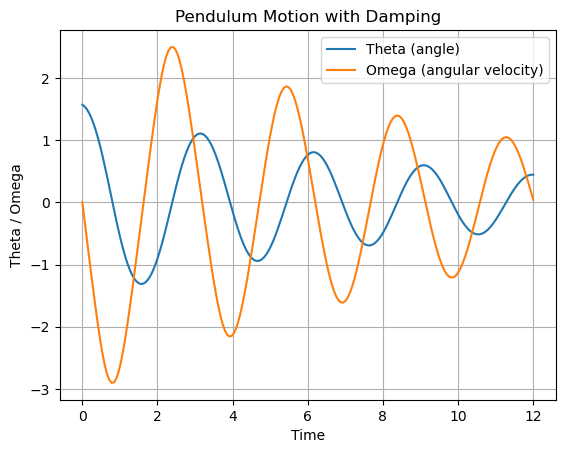

In [3]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Function that computes the derivatives
def dfdt(y0,t,params):
    theta, omega = y0
    GdivL, betaDivm = params
    derivs = [omega - betaDivm*theta, -GdivL * np.sin(theta) ]
    return derivs

# Parameters
betaDivm = 0.2
GdivL = 4.9

params = [GdivL, betaDivm]

# Initial conditions
theta0 = np.pi/2.0
omega0 = 0.0
y0 = [theta0, omega0]

# Solve equations and plot
t = np.linspace(0.0, 12.0, 200)
sol = odeint(dfdt, y0, t, args=(params,))
theta = sol[:,0]
omega = sol[:,1]

plt.plot(t, theta,t,omega)
plt.xlabel('Time')
plt.ylabel('Theta / Omega')
plt.title('Pendulum Motion with Damping')
plt.legend(['Theta (angle)','Omega (angular velocity)'])
plt.grid(True)
plt.show()